In [1]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib
import nilearn

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils
from utils import load_preprocess_betas, resample, applyxfm, apply_thresh, resample_betas

# this block imports utils from mindeye_preproc as "preproc"
import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

importing modules


In [2]:
from accelerate import Accelerator, DeepSpeedPlugin
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

import os
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

LOCAL RANK  0
device: cuda


# Data

## New Design

In [3]:
if utils.is_interactive():
    sub = "sub-005"
    session = "all"
    task = 'C'  # 'study' or 'A'; used to search for functional run in bids format
else:
    sub = os.environ["sub"]
    session = os.environ["session"]
    task = os.environ["task"]

if session == "all":
    ses_list = ["ses-01", "ses-02"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-02"]  # list of session IDs to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]
    
task_name = f"_task-{task}" if task != 'study' else ''
resample_voxel_size = False
resample_post_glmsingle = False  # do you want to do voxel resampling here? if resample_voxel_size = True and resample_post_glmsingle = False, assume the resampling has been done prior to GLMsingle, so just use resampled directory but otherwise proceed as normal
load_from_resampled_file = False  # do you want to load resampled data from file? if True, assume resampling was done in this notebook before, and that we're not using the GLMsingle resampled data
    
train_test_split = 'MST' # 'MST', 'orig', 'unique'
remove_close_to_MST = False
remove_random_n = False

if remove_close_to_MST or remove_random_n:
    assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

n_to_remove = 0
if remove_random_n:
    assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
    n_to_remove = 150
    
if resample_voxel_size:
    # voxel size was unchanged in glmsingle, want to perform resampling here
    resampled_vox_size = 2.5
    resample_method = "sinc"  # {trilinear,nearestneighbour,sinc,spline}, credit: https://johnmuschelli.com/fslr/reference/flirt.help.html
    
    # file name helper variables
    vox_dim_str = str(resampled_vox_size).replace('.', '_')  # in case the voxel size has a decimal, replace with an underscore
    resampled_suffix = f"resampled_{vox_dim_str}mm_{resample_method}"
    mask_resampled_suffix = resampled_suffix
    if resample_post_glmsingle:
        resampled_suffix += '_postglmsingle'
    else:
        resampled_suffix += '_preglmsingle'

In [4]:
session_label = preproc.get_session_label(ses_list)
print('session label:', session_label)
n_runs, _ = preproc.get_runs_per_session(sub, session, ses_list)

session label: ses-01-02


In [5]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # model_name=f"{sub}_{session}_task-{task}_bs24_MST_rishab_{train_test_split}split"
    model_name = "sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0"
    print("model_name:", model_name)
    glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{task}"
    print("glmsingle_path:", glmsingle_path)
    assert os.path.exists(glmsingle_path)
    print("glmsingle path exists!")
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 \
                    --glmsingle_path={glmsingle_path} \
                    --model_name={model_name} --subj=1 \
                    --no-blurry_recon --use_prior \
                    --hidden_dim=1024 --n_blocks=4"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0
glmsingle_path: /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C
glmsingle path exists!
--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2                     --glmsingle_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C                     --model_name=sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0 --subj=1                     --no-blurry_recon --use_prior                     --hidden_dim=1024 --n_blocks=4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--glmsingle_path",type=str,default="/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01",
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# make output directory
# os.makedirs("evals",exist_ok=True)
# os.makedirs(f"evals/{model_name}",exist_ok=True)

In [7]:
if session == "all":
    filename = f"csv/{sub}_{ses_list[0]}.csv"
    data = pd.read_csv(filename)[14:]
    print(filename)
    print(data.shape)
    for s in ses_list[1:]:
        filename = f"csv/{sub}_{s}.csv"
        print(filename)
        data = pd.concat([data, pd.read_csv(filename)[14:]])
        print(data.shape)
else:
    filename = f"csv/{sub}_{session}.csv"
    if sub == 'sub-001' and session == 'ses-01':
        data = pd.read_csv(filename)[23:]
    else: 
        data = pd.read_csv(filename)[14:]
    print(filename)
    print(data.shape)

image_names = data['current_image'].values
starts = data['trial.started'].values
is_new_run = data['is_new_run'].values

if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
# unique_images = unique_images[(unique_images!="blank.jpg")]
len_unique_images = len(unique_images)
print("len_unique_images",len_unique_images)
print("n_runs",n_runs)

if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

if remove_random_n:
    # want to remove 150 imgs
    # 100 special515 imgs are repeated 3x (300 total)
    # all other train imgs are only shown once (558 total)
    # of the 150, want to sample proportionally since we're cutting all repeats for special515
    # so take out 51 (17 unique) from special515 and 99 from rest = removing 150 total
    np.random.seed(seed)
    options_to_remove = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' not in x and list(image_names).count(x)==1]  # all the imgs that only appear once (this is O(N^2) b/c of count() within list comprehension but image_names is a relatively small list)
    options_to_remove_special515 = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' in x and list(image_names).count(x)>1]  # all the special515 images that are repeated (count()>1 necessary because there are special515 that are not repeated)
    imgs_to_remove = np.random.choice(options_to_remove, size=99, replace=False)
    imgs_to_remove = np.append(imgs_to_remove, np.random.choice(options_to_remove_special515, size=17, replace=False))

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i+=1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i+=1
            continue
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):  # MST images are ones that matched these image titles
        import re
        if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):  
        # the regexp here looks for **_***.png, allows 1-2 chars before underscore and 1-3 chars after it
            # print(im)
            all_MST_images[i] = im
            i+=1            
    elif 'MST' in im:
        all_MST_images[i] = im
        i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)
if remove_close_to_MST:
    close_to_MST_idx = np.array([], dtype=int)
if remove_random_n:
    random_n_idx = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            i+=1
            continue
    if remove_random_n:
        if im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            i+=1
            j+=1
            continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100

csv/sub-005_ses-01.csv
(790, 122)
csv/sub-005_ses-02.csv
(1575, 122)
len_unique_images 1001
n_runs 22
['all_stimuli/special515/special_15939.jpg'
 'all_stimuli/special515/special_23241.jpg'
 'all_stimuli/special515/special_32232.jpg'
 'all_stimuli/special515/special_34238.jpg']
[190.2773371 194.2907918 198.3011098 202.3095724]
[0. 0. 0. 0.]
(1386,)


In [8]:
# unique_images_pairs = [
#     (1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16),
#     (17,18),(19,20),(21,22),(23,24),(25,26),(27,28),(29,30),
#     (31,32),(33,34),(35,36),
#     (787, 788), (789, 790), (791, 792), (793, 794), (795, 796),
#     (797, 798), (799, 800), (801, 802), (803, 804), (805, 806),
#     (807, 808), (809, 810), (811, 812), (813, 814), (815, 816),
#     (817, 818), (819, 820), (821, 822), (823, 824), (825, 826),
#     (827, 828), (829, 830), (831, 832), (833, 834), (835, 836),
#     (837, 838), (839, 840), (841, 842), (843, 844), (845, 846),
#     (847, 848), (849, 850)
# ]
# unique_images[unique_images_pairs]

In [9]:
import imageio.v2 as imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    if sub == 'sub-001' and session == 'ses-01':
        image_file = f"all_stimuli/rtmindeye_stimuli/{unique_images[im_name]}"
    else:
        image_file = f"{unique_images[im_name]}"
    im = imageio.imread(image_file)
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
        if ('w_' in image_file or 'paired_image_' in image_file or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', image_file) or re.match(r'all_stimuli/rtmindeye_stimuli/images/\d{1,2}_\d{1,3}\.png$', image_file)):  
            MST_images.append(True)
        else:
            MST_images.append(False)
    else:   
        if ("MST_pairs" in image_file): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
            MST_images.append(True)
        else:
            MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(MST_images[MST_images==True]) == 100
print("MST_images==True", len(MST_images[MST_images==True]))

  0%|          | 0/1386 [00:00<?, ?it/s]/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1386/1386 [00:48<00:00, 28.78it/s]


images torch.Size([1386, 3, 224, 224])
MST_images 1386
MST_images==True 248


In [10]:
pairs = utils.find_paired_indices(image_idx)
pairs = sorted(pairs, key=lambda x: x[0])

In [11]:
vox = None
needs_postprocessing = False
params = (session, ses_list, remove_close_to_MST, image_names, remove_random_n, vox_idx)

if resample_post_glmsingle == True:
    glm_save_path_resampled = f"{glmsingle_path}/vox_resampled.nii.gz"
    if load_from_resampled_file == True:
        # resampling was done in this notebook so we can load from file
        vox = nib.load(glm_save_path_resampled)
    else:
        # do resampling here
        assert os.path.exists(ref_name) and os.path.exists(omat_name), "need to generate the boldref and omat separately since we don't have access to the functional data here; either do so using flirt on the command line or copy over the glmsingle resampled outputs"
        vox = load_preprocess_betas(orig_glmsingle_path, *params)
        vox = resample_betas(orig_glmsingle_path, sub, session, task_name, vox, glmsingle_path, glm_save_path_resampled, ref_name, omat_name)
    needs_postprocessing = True

if vox is None:
    # either resampling was done in glmsingle or we aren't resampling 
    vox = load_preprocess_betas(glmsingle_path, *params)

if needs_postprocessing == True:
    vox = apply_mask(vox, avg_mask)
    vox = vox.reshape(-1, vox.shape[-1])  # flatten the 3D image into np array with shape (voxels, images)
    print(vox.shape)

assert len(vox) == len(image_idx)

vox (1386, 1, 1, 182468)
vox (1386, 182468)


In [12]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi

mask_name = f'{glmsingle_path}/{sub}_{session_label}{task_name}_brain'
if resample_voxel_size:
    if resample_post_glmsingle is True:
        # use original mask directory
        mask_in_name = f'{orig_glmsingle_path}/{sub}_{session}{task_name}_brain.nii.gz'
        mask_out_name = mask_name + f"_{mask_resampled_suffix}.nii.gz"
        assert os.path.exists(mask_in_name)
        applyxfm(mask_in_name, ref_name, omat_name, resample_method, output=mask_out_name)
        apply_thresh(mask_out_name, 0.5, output=mask_out_name)  # binarize the mask since resampling can result in non- 0 or 1 values
    mask_name += f"_{mask_resampled_suffix}"

mask_name += ".nii.gz"
print(mask_name)
avg_mask = nib.load(mask_name)
# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C/sub-005_ses-01-02_task-C_brain.nii.gz
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 182468 voxels in the included brain mask



In [13]:
nsdgeneral_path = f'{glmsingle_path}/{sub}_{session_label}{task_name}_nsdgeneral.nii.gz'  
print(nsdgeneral_path)
assert os.path.exists(nsdgeneral_path)
print(f"nsdgeneral path exists!")

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C/sub-005_ses-01-02_task-C_nsdgeneral.nii.gz
nsdgeneral path exists!


In [14]:
if resample_voxel_size:
    nsdgeneral_path = f'{glmsingle_path}/{sub}_task-{task}_nsdgeneral_resampled.nii.gz'  
    if resample_post_glmsingle:
        assert os.path.exists(orig_glmsingle_path)
        roi_in_path = f"{orig_glmsingle_path}/{sub}_task-{task}_nsdgeneral.nii.gz"  # the input file is the original nsdgeneral mask (without resampling), from the original glmsingle directory
        applyxfm(roi_in_path, ref_name, omat_name, resample_method, output=nsdgeneral_path)

(76, 90, 74)


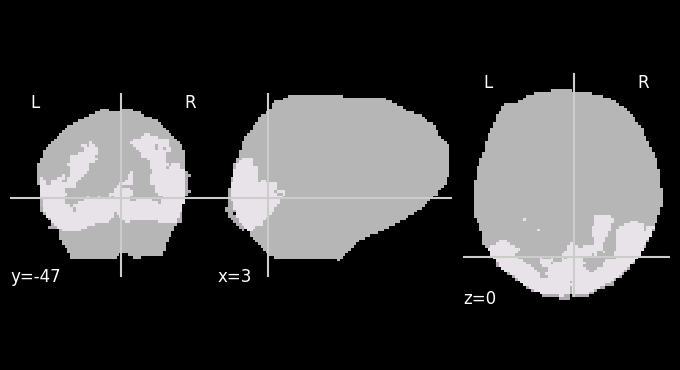

In [15]:
roi = nib.load(nsdgeneral_path)
print(roi.shape)
plot_roi(roi, bg_img=avg_mask)
plt.show()

In [16]:
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[avg_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 182468
nsdgeneral voxels = 19302


In [17]:
# ROI masking?
print(f"vox before ROI exclusion: {vox.shape}")
vox = vox[:,roi]
print(f"vox after ROI exclusion: {vox.shape}")

if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x,y = np.where(np.isnan(vox))
    vox = vox[:,np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox before ROI exclusion: (1386, 182468)
vox after ROI exclusion: (1386, 19302)


In [18]:
pairs_homog = np.array([[p[0], p[1]] for p in pairs])

In [19]:
vox_pairs = utils.zscore(vox[pairs_homog])
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape)
assert np.sum(np.all(np.isnan(rels))) == 0

100%|██████████| 19302/19302 [00:01<00:00, 17349.27it/s]

rels (19302,)


In [20]:
# creating img x vox x repetitions matrix | shape=(150, 18419, 2)
vox0 = np.zeros((len(pairs_homog), vox.shape[-1], 2))
print(vox0.shape)
for ipair, pair in enumerate(tqdm(pairs_homog)):
    pair = pair[:2] # to keep things consistent, just using the first two repeats
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T
vox_avg = vox0.mean(-1) # average across the repetitions

(162, 19302, 2)


100%|██████████| 162/162 [00:00<00:00, 3290.51it/s]


In [21]:
# Reliability thresholding?
print(f"\nvox before reliability thresholding: {vox.shape}")
vox = vox[:,rels>.2]
print(f"\nvox after reliability thresholding: {vox.shape}")


vox before reliability thresholding: (1386, 19302)

vox after reliability thresholding: (1386, 1053)


In [22]:
print(images.shape)
print(vox.shape)

torch.Size([1386, 3, 224, 224])
(1386, 1053)


In [23]:
utils.seed_everything(seed)

# add_repeats = 48
# imageTrain = np.arange(len(images))
# train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
# train_image_indices = np.sort(np.append(train_image_indices, np.array(pairs[:add_repeats].flatten())))

# # check that there's no repeat indices in training data
# assert len(sorted(np.append(np.array([item for item in imageTrain if item not in pairs.flatten()]), np.array(pairs[:add_repeats].flatten())))) == len(set(sorted(np.append(np.array([item for item in imageTrain if item not in pairs.flatten()]), np.array(pairs[:add_repeats].flatten())))))

# test_image_indices = pairs[add_repeats:]
# print(len(train_image_indices), len(test_image_indices))

if train_test_split == 'orig':
    # train = all images except images that were repeated
    # test = average of the same-image presentations
    imageTrain = np.arange(len(images))
    train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
    test_image_indices = pairs
    print(len(train_image_indices), len(test_image_indices))
elif train_test_split == 'MST':
    # non-MST images are the train split
    # MST images are the test split
    train_image_indices = np.where(MST_images==False)[0]
    test_image_indices = np.where(MST_images==True)[0]
    print(len(train_image_indices), len(test_image_indices))
    # for i in test_image_indices:
    #     assert i in pairs  # all MST images have pairs

1138 248


In [24]:
# test_image_indices

In [25]:
# repeats_in_test = []
# for p in pairs:
#     group = []
#     for item in p:
#         curr = np.where(test_image_indices == item)
#         if curr[0].size > 0:
#             group.append(curr[0][0])
#     # print(np.array(group))
#     if len(group) > 0:
#         repeats_in_test.append(np.array(group))
#     # if p[0] in test_image_indices:
#     #     repeats_in_test.append(p)
        
# repeats_in_test = np.array(repeats_in_test)


In [26]:
train_mean = np.mean(vox[train_image_indices],axis=0)
train_std = np.std(vox[train_image_indices],axis=0)

vox = utils.zscore(vox,train_mean=train_mean,train_std=train_std)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())
print("vox", vox.shape)

images = torch.Tensor(images)
vox = torch.Tensor(vox)

voxels have been zscored
-0.0318167 1.0120775
vox (1386, 1053)


In [27]:
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

# Model

In [28]:
subj_list = [subj]
subj = subj_list[0]
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Loaded test dl for subj1!



In [29]:
test_voxels, test_images = None, None
for test_i, behav in enumerate(test_dl):
    behav = behav[0]

    if behav.ndim>1:
        test_image = images[behav[:,0].long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()].mean(1)
    else:
        test_image = images[behav.long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()]
    
    if test_voxels is None:
        test_voxels = test_vox
        test_images = test_image
    else:
        test_voxels = torch.vstack((test_voxels, test_vox))
        test_images = torch.vstack((test_images, test_image))

print(test_i, len(test_voxels), len(test_images))

0 248 248


In [30]:
num_voxels_list = []
num_voxels_list.append(test_voxels.shape[-1])

In [31]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [32]:
import utils

In [33]:
model = utils.prepare_model_and_training(
    num_voxels_list=num_voxels_list,
    n_blocks=n_blocks,
    hidden_dim=hidden_dim,
    clip_emb_dim=clip_emb_dim,
    clip_seq_dim=clip_seq_dim,
    use_prior=use_prior,
    clip_scale=clip_scale
)

MindEyeModule()
param counts:
1,079,296 total
1,079,296 trainable
param counts:
1,079,296 total
1,079,296 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
454,439,576 total
454,439,576 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
714,304,792 total
714,304,776 trainable


In [ ]:
# prep unCLIP
config = OmegaConf.load("/scratch/gpfs/ri4541/MindEyeV2/src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/unclip6_epoch0_step110000.ckpt' 
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

In [ ]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
# processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
# clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
processor = AutoProcessor.from_pretrained("/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2")

clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load("/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

In [ ]:
# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
del checkpoint
print("ckpt loaded!")

In [31]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_blurryrecons = None
all_images = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 32
num_samples_per_image = 1
plotting = True

with torch.no_grad():
    for batch in tqdm(range(0,len(test_images),minibatch_size)):
        start_time = time.time() 

        image = test_images[batch:batch+minibatch_size]
        voxel = test_voxels[batch:batch+minibatch_size].unsqueeze(1).to(device)

        # Save ground truth images
        if all_images is None:
            all_images = image
        else:
            all_images = torch.vstack((all_images, image))
        
        voxel_ridge = model.ridge(voxel,0)
        backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
                
        # Save retrieval submodule outputs
        if clip_scale>0:
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
                
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20).cpu()
        
        if all_prior_out is None:
            all_prior_out = prior_out
        else:
            all_prior_out = torch.vstack((all_prior_out, prior_out))

        pred_caption_emb = clip_convert(prior_out.to(device).float())
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        if plotting:
            jj=-1
            fig, axes = plt.subplots(1, 12, figsize=(10, 4))

        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
                
            if plotting:  
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(image[i]))
                axes[jj].axis('off')
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(samples.cpu()[0]))
                axes[jj].axis('off')
        
        plt.show()

        print(model_name)
        # err # dont actually want to run the whole thing with plotting=True

# resize outputs before saving
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images).float()
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
        
## Saving ##
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

if "MST" in model_name:
    np.save(f"{eval_dir}/{model_name}_MST_ID.npy", MST_ID)
torch.save(all_images.cpu(),f"{eval_dir}/{model_name}_all_images.pt")

# repeats_in_test = []
# for p in pairs:
#     if p[0] in test_image_indices:
#         repeats_in_test.append(p)
        
# repeats_in_test = np.array(repeats_in_test)

# torch.save(test_image_indices, f"{eval_dir}/{model_name}_test_image_indices.pt")
# torch.save(repeats_in_test, f"{eval_dir}/{model_name}_repeats_in_test.pt")
torch.save(all_recons,f"{eval_dir}/{model_name}_all_recons.pt")
if clip_scale>0:
    torch.save(all_clipvoxels,f"{eval_dir}/{model_name}_all_clipvoxels.pt")
torch.save(all_prior_out,f"{eval_dir}/{model_name}_all_prior_out.pt")
torch.save(all_predcaptions,f"{eval_dir}/{model_name}_all_predcaptions.pt")
print(f"saved {model_name} outputs!")

  0%|          | 0/4 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a kitchen with a counter and a microwave.', 'a cat is sitting on a table.', 'a large room with a lot of furniture.', 'a giraffe standing next to a tree.', 'a room with a view.', 'a room with a lot of furniture.', 'a large field with a lot of grass.', 'a kitchen with a lot of furniture.', 'a large room with a lot of furniture.', 'a garden with a plant and a fence.', 'a kitchen with a lot of furniture.', 'a kitchen with a counter and a stove', 'a room with a view', 'a plate with a cake on it', 'a snowboarder is skiing down a hill.', 'a clock on a building.', 'a young boy is standing in a pool of water.', 'a bed or beds in a room at the inn', 'a large building with a clock on it.', 'a room with a lot of furniture.', 'a table with a bunch of items on it', 'a tree with a lot of leaves.', 'a night view of a city.', 'a white wall', 'a large building with a clock on it.', 'a large group of people.', 'a small room with a clock and a vase.', 'a large truck is parked next to a building.', 'a ro

/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 25%|██▌       | 1/4 [02:21<07:04, 141.65s/it]

sub-001_ses-01_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a train is driving through a field.', 'a cat sitting on a table.', 'a zebra standing in a field.', 'a plate of food', 'a car driving down a street.', 'a large field with a bunch of people on it', 'a man on a boat in a lake.', 'a view of a table.', 'a large area with a lot of grass.', 'a display of a cell phone.', 'a bunch of different types of flowers', 'a large open area with a lot of space for a small table.', 'a room with a lot of furniture.', 'a large planter with a bunch of flowers on it.', 'a bathroom with a shower and a sink.', 'a large body of water.', 'a street light and a street sign', 'a plate with a piece of food on it', 'a room with a view', 'a bunch of flowers on a table.', 'a small table with a small display.', 'a glass door with a window.', 'a stuffed toy bear is sitting on a table.', 'a small tree in a field.', 'a plate of food with a fork.', 'a snowboarder is on a hill.', 'a room with a lot of furniture.', 'a bathroom with a toilet and a sink.', 'a table with a bunc

 50%|█████     | 2/4 [04:42<04:42, 141.19s/it]

sub-001_ses-01_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man on a surfboard in the water.', 'a woman standing on a sidewalk next to a water.', 'a table with a plate and a plate on it', 'a large truck is parked on the side of the road.', 'a clock tower with a tower in the background.', 'a room with a lot of furniture.', 'a white wall with a window', 'a glass door with a window.', 'a picture of a tree.', 'a view of a large room.', 'a grassy field with a few animals in it.', 'a white wall', 'a plate of food with a fork.', 'a plate with a piece of food on it', 'a clock tower with a tower in the background.', 'a clock tower with a tower in the background.', 'a room with a view.', 'a laptop computer sitting on top of a table.', 'a zebra standing on a dirt field.', 'a surfer riding a wave on a sunny day.', 'a toilet with a lid', 'a room with a table and chairs.', 'a kitchen with a sink and a counter', 'a bathroom with a sink and a mirror.', "a close up of a person's head", 'a group of animals standing on a field.', 'a white table with a glass t

 75%|███████▌  | 3/4 [07:04<02:21, 141.66s/it]

sub-001_ses-01_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a room with a bed and a television.', 'a large building with a clock on it.', 'a man on a surfboard in the water.', 'a train is driving down the tracks.']


100%|██████████| 4/4 [07:22<00:00, 110.66s/it]

sub-001_ses-01_bs24_MST_rishab_MSTsplit



/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


saved sub-001_ses-01_bs24_MST_rishab_MSTsplit outputs!


In [ ]:
if "MST" in model_name:
    np.save(f"{eval_dir}/{model_name}_MST_ID.npy", MST_ID)

In [ ]:
all_images.shape

In [ ]:
x = torch.permute(all_images, (0,2,3,1))
y = torch.permute(all_recons, (0,2,3,1))

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(8, 8))
for row, _ in enumerate(ax):
    ax[row][0].imshow(x.cpu()[row])
    ax[row][1].imshow(y.cpu()[row])
plt.tight_layout()
plt.show()